<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#5d3a8e; font-size:40px'> Topic Modeling with Gensim (Python)</h1>
</div>

# 1. Prerequisites Installation

In [1]:
#! bash /content/Prerequisites.txt

In [2]:
import warnings
warnings.filterwarnings("ignore")

 # 2. Import and prepare the Data

In [3]:
import re
import numpy as np
import pandas as pd

In [4]:
# Import Dataset
df = pd.read_excel("/content/dataset/Pubmed5k.xlsx")
df.head()

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...


In [5]:
def clean_data (df: pd.DataFrame):

  """
  This function Extracts the text columns from the dataset and cleans it

  Parameters
  ----------
  df: the dataframe with columns ["ArticleID","Title","Abstract"]

  Returns
  -------
  list of the cleaned articls text from the dataset 
  
  """

  #combine the ['Title', 'Abstract'] columns to one column
  df["Article"] = df[['Title', 'Abstract']].agg(' '.join, axis=1)

  # remove unwanted ID column
  df = df.drop(columns = ["ArticleID","Title","Abstract"])

  # Convert to list
  data = df.values.tolist()

  # Remove new line characters
  data = [re.sub('\s+', ' ', str(sent)) for sent in data]

  # Remove distracting single quotes
  data = [re.sub("\'"," ", str(sent)) for sent in data] 

  return data

In [6]:
data = clean_data(df)

In [7]:
data[0]

'[ Stable Coordination Variability in Overground Walking and Running at Preferred and Fixed Speeds. Coordination variability (CV) is commonly analyzed to understand dynamical qualities of human locomotion. The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion. Three-dimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running. Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique. The number of trials required to achieve a CV mean within 10% of 20 strides average was determined for each coupling and individual. The statistical outputs of mode (walking vs running) and speed (preferred vs fixed) were compared when informed by differing numbers of trials. A minimum of 11 trials were required for stable mean stance phase CV. With fewe

In [8]:
import spacy

In [9]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [10]:
lemmatized_data = lemmatization(data)

In [11]:
print (lemmatized_data[0])

stable run coordination variability commonly analyze understand dynamical quality human locomotion purpose study develop guideline number trial require inform calculation stable mean low limb overground locomotion dimensional low limb kinematic capture recreational runner perform trial preferred fix speed walk run stance phase calculate segment joint coupling use modify vector code technique number trial require achieve mean % stride average determine coupling individual statistical output mode walk run speed prefer fix compare when inform differ number trial minimum trial require stable mean stance phase few trial underestimate lead oversight significant difference mode speed future overground locomotion research healthy population use vector code approach use trial standard minimum researcher aware notable consequence insufficient number trial overall study finding


In [12]:
lemmatized_data[0]

'stable run coordination variability commonly analyze understand dynamical quality human locomotion purpose study develop guideline number trial require inform calculation stable mean low limb overground locomotion dimensional low limb kinematic capture recreational runner perform trial preferred fix speed walk run stance phase calculate segment joint coupling use modify vector code technique number trial require achieve mean % stride average determine coupling individual statistical output mode walk run speed prefer fix compare when inform differ number trial minimum trial require stable mean stance phase few trial underestimate lead oversight significant difference mode speed future overground locomotion research healthy population use vector code approach use trial standard minimum researcher aware notable consequence insufficient number trial overall study finding'

# 3. Tokenize words

The sentences look better now, but you want to tokenize each sentence into a list of words, removing punctuations and unneccessary characters altogether.

Gensim's `simple_preprocess()` is great for this. Additionally I have set `deacc=True` to remove the punctuations.

In [13]:
# Gensim
import gensim

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)



In [14]:
def sent_to_words(sentences):
  """
  This function Tokenize sentences to words and removes the punctuation

  Parameters
  ----------
  sentences: list of the articls text

  Returns
  -------
  list of lists of the Tokenized sentences
  """
  tokenized =list()

  for sentence in sentences:
      tokenized.append(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))
  
  return tokenized


In [15]:
data_words = sent_to_words(lemmatized_data)
print(data_words[:1])


[['stable', 'run', 'coordination', 'variability', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'human', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'mean', 'low', 'limb', 'overground', 'locomotion', 'dimensional', 'low', 'limb', 'kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'preferred', 'fix', 'speed', 'walk', 'run', 'stance', 'phase', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'code', 'technique', 'number', 'trial', 'require', 'achieve', 'mean', 'stride', 'average', 'determine', 'coupling', 'individual', 'statistical', 'output', 'mode', 'walk', 'run', 'speed', 'prefer', 'fix', 'compare', 'when', 'inform', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance', 'phase', 'few', 'trial', 'underestimate', 'lead', 'oversight', 'significant', 'difference', 'mode', 'speed', 'future', 'overground', 'locomotion', 're

# 4. Remove Stopwords and Make multigrams


The bigrams model is ready. Let's define the functions to remove the stopwords, make multigrams.

### Remove Stopwords

In [16]:
import nltk; 
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [18]:
from gensim.utils import simple_preprocess

In [19]:
def remove_stopwords(texts):
  """
  This function remove the stop words from the texts
  """
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

### Make Bigrams and Trigrams

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [22]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [23]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [24]:
# Form Bigrams and trigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_bigrams)

# 5. Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(`id2word`) and the corpus. Let's create them.

In [25]:
import gensim.corpora as corpora
from gensim.models import TfidfModel

In [26]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_words_trigrams)

texts = data_words_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [27]:
id2word[0]

'achieve'

Or, you can see a human readable form of the corpus itself.

In [28]:
corpus[:1][0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 1)]

In [29]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('achieve', 1),
  ('analyze', 1),
  ('approach', 1),
  ('average', 1),
  ('aware', 1),
  ('calculate', 1),
  ('calculation', 1),
  ('capture', 1),
  ('code', 2),
  ('commonly', 1),
  ('consequence', 1),
  ('coordination', 1),
  ('coupling', 2),
  ('determine', 1),
  ('differ', 1),
  ('difference', 1),
  ('dimensional', 1),
  ('dynamical', 1),
  ('finding', 1),
  ('fix', 2),
  ('future', 1),
  ('guideline', 1),
  ('healthy', 1),
  ('human', 1),
  ('individual', 1),
  ('inform', 2),
  ('insufficient', 1),
  ('joint', 1),
  ('kinematic', 1),
  ('lead', 1),
  ('limb', 2),
  ('locomotion', 3),
  ('low', 2),
  ('mean', 3),
  ('minimum', 2),
  ('mode', 2),
  ('modify', 1),
  ('notable', 1),
  ('number', 4),
  ('output', 1),
  ('overall', 1),
  ('overground', 2),
  ('oversight', 1),
  ('perform', 1),
  ('phase', 2),
  ('population', 1),
  ('prefer', 1),
  ('preferred', 1),
  ('purpose', 1),
  ('quality', 1),
  ('recreational', 1),
  ('require', 3),
  ('research', 1),
  ('researcher', 1),
  (

# 6. Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. 

Apart from that, `alpha` and `eta` are hyperparameters that affect sparsity of the topics. According to the gensim docs, both defaults to 1.0/num_topics prior.

`chunksize` is the number of documents to be used in each training chunk.  `update_every` determines how often the model parameters should be updated and `passes` is the total number of training passes.

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 7. View the topics in LDA model

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()` as shown next.

In [31]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.016*"research" + 0.015*"pandemic" + 0.014*"impact" + 0.014*"social" + 0.012*"work" + 0.011*"support" + 0.010*"mental_health" + 0.009*"behavior" + 0.008*"relate" + 0.008*"depression"'), (1, '0.032*"cell" + 0.017*"protein" + 0.010*"activity" + 0.010*"induce" + 0.008*"drug" + 0.008*"human" + 0.007*"tissue" + 0.007*"implant" + 0.006*"surface" + 0.006*"interaction"'), (2, '0.031*"use" + 0.030*"model" + 0.024*"base" + 0.021*"method" + 0.019*"datum" + 0.014*"performance" + 0.012*"test" + 0.010*"sample" + 0.010*"detection" + 0.010*"result"'), (3, '0.114*"stress" + 0.020*"spinal" + 0.019*"compression" + 0.016*"psychological_distress" + 0.014*"trust" + 0.014*"ground" + 0.013*"artery" + 0.012*"southern" + 0.012*"min" + 0.010*"biomechanical"'), (4, '0.029*"brain" + 0.028*"function" + 0.019*"policy" + 0.019*"cognitive" + 0.016*"mitochondrial" + 0.015*"restoration" + 0.013*"attribute" + 0.012*"probe" + 0.012*"cardiac" + 0.012*"effect"'), (5, '0.057*"patient" + 0.020*"group" + 0.017*"treatmen

#8. Compute Model Perplexity and Coherence Score


Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [32]:
from gensim.models import CoherenceModel

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.039897018997143

Coherence Score:  0.44587124056629523


# 9. Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [34]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.131401  0.143194       1        1  18.199320
6      0.122791  0.020300       2        1  16.364581
9      0.153523  0.208433       3        1  13.818173
1     -0.061008  0.144891       4        1  12.392937
7      0.113276 -0.266441       5        1  10.255752
2      0.128373 -0.105233       6        1  10.229538
0      0.082740 -0.151462       7        1   9.733136
8     -0.143438  0.113087       8        1   5.833388
4     -0.289354 -0.049590       9        1   2.583711
3     -0.238303 -0.057180      10        1   0.589462, topic_info=                         Term         Freq        Total Category  logprob  \
162                   patient  5286.000000  5286.000000  Default  30.0000   
367                      cell  2007.000000  2007.000000  Default  29.0000   
66                      study  1857.000000  1857.000000  Default  28.0000   
281                    health  1669.000000  1669.000000  Default  27.0000   
160                     model  1580.000000  1580.000000  Default  26.0000   
...                       ...          ...          ...      ...      ...   
9207                 overlook    16.518336    17.446285  Topic10  -5.2111   
21263              gait_speed    17.619479    18.616106  Topic10  -5.1466   
5027   mechanical_ventilation    16.047430    16.974996  Topic10  -5.2401   
12365                 modulus    15.741783    16.669432  Topic10  -5.2593   
2301                   decide    15.293411    16.221358  Topic10  -5.2882   

       loglift  
162    30.0000  
367    29.0000  
66     28.0000  
281    27.0000  
160    26.0000  
...        ...  
9207    5.0791  
21263   5.0787  
5027    5.0775  
12365   5.0765  
2301    5.0748  

[509 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1374      5  0.993085  academic
310       5  0.996673    access
1924      6  0.997352  accuracy
355       6  0.997219  accurate
1035      4  0.996773      acid
...     ...       ...       ...
4303      9  0.995835        xa
182       1  0.348316      year
182       3  0.651058      year
262       1  0.009737     young
262       3  0.989973     young

[763 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 10, 2, 8, 3, 1, 9, 5, 4])

#10. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet's LDA from within gensim itself. You only need to [download](http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip) the zipfile, unzip it and provide the path to mallet in the unzipped directory to `gensim.models.wrappers.LdaMallet`.

In [36]:
mallet_path = '/content/models/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed= 0)

In [37]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts= data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('risk', 0.03459331413751557), ('factor', 0.026322775633564093), ('associate', 0.02542424799362862), ('age', 0.02528130041454798), ('child', 0.023239192141967367), ('year', 0.019502134003144846), ('high', 0.018399395535951317), ('woman', 0.01615307643611264), ('population', 0.01490739038983847), ('association', 0.012967387530886887)]), (1, [('group', 0.04520683949255378), ('level', 0.030865968008825153), ('effect', 0.025835631549917266), ('control', 0.023541092112520683), ('time', 0.021599558742415884), ('increase', 0.02144511858797573), ('change', 0.01619415333701048), ('compare', 0.015730832873690016), ('high', 0.01504688361831219), ('low', 0.014826254826254825)]), (2, [('specie', 0.03340307165612667), ('describe', 0.01478769435595074), ('region', 0.013289905377775664), ('area', 0.012362702677000618), ('type', 0.00979506442870049), ('distribution', 0.008701440730350436), ('plant', 0.007964433455375399), ('environmental', 0.00760781703200038), ('pattern', 0.007536493747325377), 

# 11. How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

The `compute_coherence_values()` (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed= 0)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts= data_words_bigrams, start=2, limit=25, step=1)

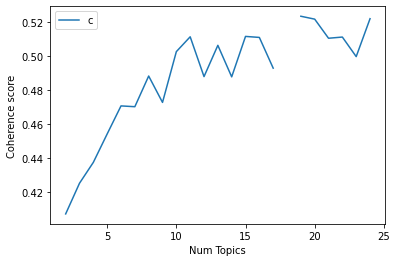

In [41]:
# Show graph
limit=25; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4071
Num Topics = 3  has Coherence Value of 0.4251
Num Topics = 4  has Coherence Value of 0.4374
Num Topics = 5  has Coherence Value of 0.4541
Num Topics = 6  has Coherence Value of 0.4706
Num Topics = 7  has Coherence Value of 0.4701
Num Topics = 8  has Coherence Value of 0.4882
Num Topics = 9  has Coherence Value of 0.4727
Num Topics = 10  has Coherence Value of 0.5025
Num Topics = 11  has Coherence Value of 0.5112
Num Topics = 12  has Coherence Value of 0.4878
Num Topics = 13  has Coherence Value of 0.5062
Num Topics = 14  has Coherence Value of 0.4877
Num Topics = 15  has Coherence Value of 0.5115
Num Topics = 16  has Coherence Value of 0.5109
Num Topics = 17  has Coherence Value of 0.4928
Num Topics = 18  has Coherence Value of nan
Num Topics = 19  has Coherence Value of 0.5233
Num Topics = 20  has Coherence Value of 0.5216
Num Topics = 21  has Coherence Value of 0.5104
Num Topics = 22  has Coherence Value of 0.5111
Num Topics = 23  has Coh

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 15 topics itself.

In [43]:
# Select the model and print the topics
optimal_model = model_list[13]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.031*"infection" + 0.025*"disease" + 0.024*"gene" + 0.015*"identify" + 0.015*"virus" + 0.012*"genetic" + 0.011*"human" + 0.011*"sequence" + 0.009*"analysis" + 0.009*"population"'), (1, '0.033*"test" + 0.030*"sample" + 0.017*"positive" + 0.015*"perform" + 0.014*"total" + 0.013*"measure" + 0.013*"evaluate" + 0.013*"detection" + 0.013*"assess" + 0.013*"determine"'), (2, '0.017*"water" + 0.012*"environmental" + 0.012*"area" + 0.011*"plant" + 0.011*"food" + 0.008*"high" + 0.007*"condition" + 0.007*"product" + 0.007*"source" + 0.007*"temperature"'), (3, '0.027*"system" + 0.016*"drug" + 0.014*"network" + 0.013*"brain" + 0.011*"development" + 0.009*"structure" + 0.009*"task" + 0.009*"field" + 0.009*"process" + 0.008*"functional"'), (4, '0.022*"pandemic" + 0.020*"impact" + 0.018*"child" + 0.015*"individual" + 0.013*"social" + 0.012*"relate" + 0.012*"people" + 0.011*"stress" + 0.010*"symptom" + 0.010*"physical"'), (5, '0.045*"risk" + 0.033*"associate" + 0.033*"age" + 0.028*"high" + 0.026*

In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model), corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.237932 -0.146859       1        1  7.537924
5     -0.125507  0.224024       2        1  7.438156
12     0.008141  0.174355       3        1  7.400063
10     0.266112  0.015911       4        1  7.094153
6     -0.049950 -0.170290       5        1  6.841783
4     -0.176730  0.027490       6        1  6.816200
13    -0.166493 -0.145433       7        1  6.785621
8     -0.109463  0.181605       8        1  6.727430
14     0.177999 -0.156813       9        1  6.519856
2      0.044216 -0.018427      10        1  6.398707
3      0.095542 -0.186466      11        1  6.251117
1     -0.032516  0.050218      12        1  6.176657
0      0.107991 -0.005613      13        1  6.160352
7      0.156452  0.190127      14        1  6.115941
11     0.042138 -0.033830      15        1  5.736039, topic_info=         Term         Freq        Total Category  logprob  loglift
162   patient  5205.000000  5205.000000  Default  30.0000  30.0000
367      cell  2229.000000  2229.000000  Default  29.0000  29.0000
215     group  2177.000000  2177.000000  Default  28.0000  28.0000
118      risk  1712.000000  1712.000000  Default  27.0000  27.0000
160     model  1648.000000  1648.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
168   provide   184.464325   654.546501  Topic15  -5.0735   1.5919
1060    small   146.261654   346.475181  Topic15  -5.3055   1.9960
604    region   162.634228   605.188570  Topic15  -5.1994   1.5444
743    family   144.078645   368.104412  Topic15  -5.3206   1.9204
732      site   140.804130   421.125026  Topic15  -5.3436   1.7628

[1213 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1542     10  1.063475  abandon
1458      1  0.124080  ability
1458      4  0.189997  ability
1458      9  0.131835  ability
1458     11  0.554481  ability
...     ...       ...      ...
1187     11  0.256353     work
182       2  0.942082     year
182       3  0.058468     year
3583     10  0.820792    yield
3583     12  0.181747    yield

[1809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 13, 11, 7, 5, 14, 9, 15, 3, 4, 2, 1, 8, 12])

Those were the topics for the chosen LDA model.

# 12. Finding the top n dominant topics in each sentence

One of the practical application of topic modeling is to determine what topics a given document is about.

To find that, we find the topics number that has the highest percentage contribution in that document.

The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, n=1):

    """
    Find the top n dominant topics in each article and aggregates this information in a presentable table 

    Parameters:
    ----------
    ldamodel : Gensim lda_model
    corpus : Gensim corpus
    texts : List of input articles text
    n: number of dominant topics

    Returns:
    -------
    sent_topics_df : a pandas Dataframe that aggregates information in a 
                     presentable way with columns ['Document_No', 'Dominant_Topics', 'Topic_Perc_Contribs','Text']
    
    """
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topics = []
        percenges = []
        for j, (topic_num, prop_topic) in enumerate(row):
            if j < n:  # => dominant topic
                topics.append(int(topic_num))
                percenges.append(round(prop_topic,4))
            else:
                break

        if n == 1:
          sent_topics_df = sent_topics_df.append(pd.Series([topics[0],percenges[0]]), ignore_index=True)
        else:
          sent_topics_df = sent_topics_df.append(pd.Series([topics,percenges]), ignore_index=True)
          
    sent_topics_df.columns = ['Dominant_Topics', 'Perc_Contributions']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [46]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data, n=3)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topics', 'Topic_Perc_Contribs','Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topics,Topic_Perc_Contribs,Text
0,0,"[8, 6, 3]","[0.1928, 0.1634, 0.1126]",[ Stable Coordination Variability in Overgroun...
1,1,"[8, 13, 7]","[0.3012, 0.1082, 0.1031]",[ Weak Hip Strength Increases Dynamic Knee Val...
2,2,"[5, 13, 6]","[0.2648, 0.1522, 0.118]",[ Current and Future Projections of Amyotrophi...
3,3,"[5, 8, 12]","[0.3083, 0.1477, 0.1445]",[ Disparities between Asian and Non-Asian Thro...
4,4,"[5, 3, 9]","[0.3041, 0.0994, 0.0852]","[""Maternal Factors Predicting Loss to Follow-U..."
5,5,"[8, 9, 13]","[0.2294, 0.2065, 0.1412]",[ Testing the feasibility and acceptability of...
6,6,"[12, 10, 8]","[0.161, 0.1239, 0.104]","[""Lupus nephritis and ANCA-associated vasculit..."
7,7,"[12, 5, 3]","[0.1538, 0.127, 0.0923]",[ Precision medicine in diabetic nephropathy a...
8,8,"[12, 0, 13]","[0.1988, 0.1254, 0.091]",[ Precision medicine in immunoglobulin A\xa0ne...
9,9,"[12, 10, 6]","[0.1539, 0.139, 0.0927]","[""Precision medicine in transplantation and he..."


# 13. Finding the most representative document for each topic.

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [47]:
# Group top 5 sentences under each topic
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data, n=1)

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd =  df_topic_sents_keywords.groupby('Dominant_Topics')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contributions'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = [
    'Topic_Num', "Topic_Perc_Contrib","Text"]

# Show
sent_topics_sorteddf_mallet


,Topic_Num,Topic_Perc_Contrib,Text
0,0.0,0.4877,[ Influence of insecticide resistance on the b...
1,1.0,0.6677,[ Adaptation of ELISA detection of Plasmodium ...
2,2.0,0.6520,[ Quantification of multi-scale links of anthr...
3,3.0,0.5945,[ HD-tDCS over motor cortex facilitates figura...
4,4.0,0.5940,"[""Comparison of Emotional Behaviour of Spanish..."
5,5.0,0.5694,[ Association between body composite indices a...
6,6.0,0.6056,[ A heuristic model-based approach for compens...
7,7.0,0.5097,[ Brain-derived Neurotropic factor (BDNF) medi...
8,8.0,0.6688,[ Initial treatment with a single pill contain...
9,9.0,0.6692,"[""Community s experience and perceptions of ma..."


# 14. Saving the model

In [48]:
#optimal_model.save("/content/models/LDA_model.model")